### Codio Activity 10.6: Time Series and Sales

**Expected Time = 60 minutes** 

**Total Points = 50** 

This activity is meant to extend your work with ARMA models to apply a forecasting model across stores in a retail chain, and items in each store.  You will build models for each store for a specific item and compare this forecast to the model aggregating all stores.  Also, you will compare a model for sales by store for all items and discuss expected performance for each store according to your forecast.  

In addition to the ARMA models, you will explore an extension of this to include seasonality elements with the SARIMA model.  These are both implemented with `statsmodels`.   

#### Index

- [Problem 1](#-Problem-1)
- [Problem 2](#-Problem-2)
- [Problem 3](#-Problem-3)
- [Problem 4](#-Problem-4)
- [Problem 5](#-Problem-5)
- [Problem 6](#-Problem-6)

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error




### The Data

The data is from a past time series competition on kaggle [here](https://www.kaggle.com/c/demand-forecasting-kernels-only).  It represents historical sales across 10 stores of 50 items.  Each observation is a days total sales by store and item.  

In [2]:
df = pd.read_csv('data/train.csv.zip', compression = 'zip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


[Back to top](#-Index)

### Problem 1

#### Structuring the data and time series

**5 Points**

To begin, notice that the DataFrame `df` does not have a datetime index.  Below, convert the `date` column to a datetime object and set it as the index to a new DataFrame called `stores_df` below.

In [5]:
### GRADED

stores_df = df
stores_df["date"] = pd.to_datetime(stores_df["date"])
stores_df = stores_df.set_index("date")

# Answer check
display(stores_df.head())
print('------------\nData Info\n')
display(stores_df.info())

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


------------
Data Info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

[Back to top](#-Index)

### Problem 2

#### Store 1 Model

**10 Points**

In anticipation of building a 30 day forecast for sales of item 1 in store 1. Subset the data to only the sales column for item 1 store 1 and assign as a DataFrame to `store_1_item_1` below. 

In [6]:
### GRADED

store_1_item_1 = stores_df.query("item == 1 and store == 1")[["sales"]]

# Answer check
store_1_item_1.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


[Back to top](#-Index)

### Problem 3

#### Train/Test split

**5 Points**

Now, use the store 1 data to create a train/test split where the train_data is all but the last 30 days of sales data.  You no longer need the store and item columns.  Assign these values as `X_train` and `X_test` respectively.

In [7]:
x = [_ for _ in range(1, 51)]
x_not_last_30 = x[:len(x) - 30]
x_last_30 = x[len(x) - 30:]
display([len(x), len(x_not_last_30), len(x_last_30)])
# display(x_not_last_30)
# display(x_last_30)
display(x == (x_not_last_30 + x_last_30))

[50, 20, 30]

True

In [8]:
### GRADED

# X_train = store_1_item_1[:len(store_1_item_1)-30]
# X_test = store_1_item_1[len(store_1_item_1)-30:]
X_train, X_test = store_1_item_1['sales'].iloc[:len(store_1_item_1)-30], store_1_item_1['sales'].iloc[len(store_1_item_1)-30:]

# Answer check
display([len(X_train),len(X_test)])
display(store_1_item_1['sales'].equals(pd.concat([X_train, X_test])))
display(X_train.head())
display(X_train.tail())
display(X_test.head())

[1796, 30]

True

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

date
2017-11-27    10
2017-11-28    14
2017-11-29    28
2017-11-30    15
2017-12-01    19
Name: sales, dtype: int64

date
2017-12-02    16
2017-12-03    31
2017-12-04     7
2017-12-05    20
2017-12-06    17
Name: sales, dtype: int64

[Back to top](#-Index)

### Problem 4

#### Assumptions of Linearity

**10 Points**

Next, you will want to check the assumptions of our model before building it.  Specifically, this was the notion that our time series is stationary for the ARMA models.  Use the `adfuller` function to determine if the series is stationary.  Assign the $p$ value to `pval` below.  Consider your threshold at $p = 0.01$.  

In [9]:
### GRADED

dftest = adfuller(X_train)
display(dftest)
pval = dftest[1]

# Answer check
print(f'The p-value is {pval: .4f}')
display(X_train.info())

(-3.099625939498424,
 0.026580883022597243,
 23,
 1772,
 {'1%': -3.4340457100503534,
  '5%': -2.8631724504188356,
  '10%': -2.5676390661481077},
 10709.450865297767)

The p-value is  0.0266
<class 'pandas.core.series.Series'>
DatetimeIndex: 1796 entries, 2013-01-01 to 2017-12-01
Series name: sales
Non-Null Count  Dtype
--------------  -----
1796 non-null   int64
dtypes: int64(1)
memory usage: 28.1 KB


None

[Back to top](#-Index)

### Problem 5

#### Autocorrelation and Partial Autocorrelation

**10 Points**

Backing up the results of our hypothesis test, the autocorrelation of the original series seems to not be stationary.  Instead, the differenced data and its ACF and PACF plot look better.  We will begin by using these plots to suggest an `order = (1, 0, 1)` model based on the differenced data.  Accordingly, build an `ARIMA` model with `order = (1, 0, 1)` and fit on the training data and assign to `arma` below.

Determine the mean squared error on the test data and assign as a float to `mse_test` below.  


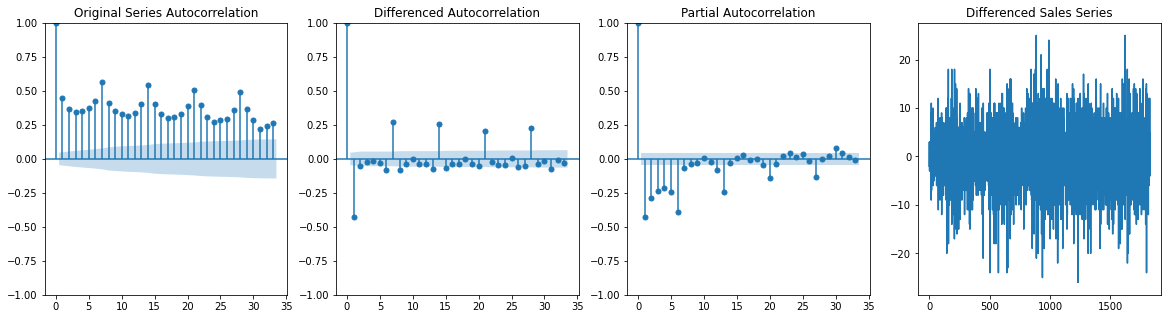

In [10]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(df[(df['store'] == 1) & (df['item'] == 1)]['sales'], ax = ax[0]);
ax[0].set_title('Original Series Autocorrelation')
plot_acf(df[(df['store'] == 1) & (df['item'] == 1)]['sales'].diff().dropna(), ax = ax[1]);
ax[1].set_title('Differenced Autocorrelation')
plot_pacf(df[(df['store'] == 1) & (df['item'] == 1)]['sales'].diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(df[(df['store'] == 1) & (df['item'] == 1)]['sales'].diff().dropna())
ax[3].set_title('Differenced Sales Series');

In [11]:
### GRADED
arma = ARIMA(X_train, order=(1, 0, 1)).fit()
preds = arma.predict()
mse_test = mean_squared_error(X_train, preds)

### ANSWER CHECK
print(preds[:5])
print(mse_test)



2013-01-01    19.455036
2013-01-02    16.645254
2013-01-03    14.941552
2013-01-04    14.744448
2013-01-05    14.431064
Freq: D, Name: predicted_mean, dtype: float64
29.08359346087692


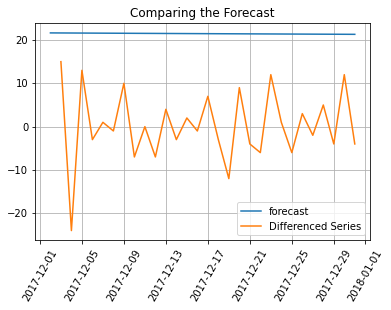

In [12]:
plt.plot(arma.forecast(steps = len(X_test)), label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.title('Comparing the Forecast')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

[Back to top](#-Index)

### Problem 6

#### A Model with Seasonality

**10 Points**

As discussed with the decomposition models earlier, there are ways to consider a seasonal oscillation within the data.  For ARIMA, a version that adds in a seasonal element is called SARIMA.  In statsmodels, we use the `SARIMAX` estimator to build this model that includes seasonal elements.

Much like the decomposition model, you can have a multiplicative or additive seasonality.  For a multiplicative seasonal effect that we determine is yearly we add an argument

```
seasonal_order=(1, 1, 0, 12)
```

along with the `order = (1, 0, 1)`.  For more information see the user guide from statsmodels [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html).

Below, build a `SARIMAX` estimator with the above order and seasonality and fit on the training data.  Assign the fit model to `sarima` below.

In [13]:
stores_df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [14]:
X_train, X_test = stores_df['sales'].iloc[-700:-30], stores_df.iloc[-30:]

In [15]:
#NOTE: in your fit statement, use .fit(disp=0)

sarima = SARIMAX(X_train, order = (1, 0, 1), seasonal_order=(1, 1, 0, 12)).fit(disp=0)

### ANSWER CHECK
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                  670
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -2863.003
Date:                             Sat, 06 Apr 2024   AIC                           5734.007
Time:                                     23:42:38   BIC                           5751.964
Sample:                                 02-01-2016   HQIC                          5740.968
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1281      0.167      0.769      0.442      -0.198       0.455
ma.L1          0.1222      0.172      0.712      0.476      -0.214       0.459
ar.S.L12      -0.4116      0.037    -10.992      0.000      -0.485      -0.338
sigma2       350.9937     19.375     18.116      0.000     313.020     388.967
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.53
Prob(Q):                              0.96   Prob(JB):                         0.06
Heteroskedasticity (H):               1.28   Skew:                             0.22
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

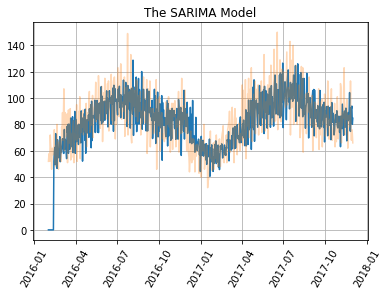

In [16]:
plt.plot(X_train.index, sarima.predict())
plt.plot(X_train.index, X_train, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model')
plt.grid();

As you see, the SARIMA model can pick up the seasonal trends we have in this dataset.  You can also get a more sensitive ARMA model by using higher order terms.  If you are interested in further work here, try grid searching order and seasonality hyperparameters to determine the best model and order/seasonality parameters. 

Also, you can incorporate other features about the data as exogenous elements of both the ARMA and SARIMA models in statsmodels.  Consider trying engineering features with `ts_fresh` and using an exogenous model to see if this improves performance.